In [24]:
import tensorflow as tf
from tensorflow import keras
from keras_tuner import HyperModel
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Завантажуємо датасет Fashion MNIST
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Масштабуємо пікселі зображень до діапазону [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

# Моделюємо форму даних для нейронної мережі
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))

In [12]:
from keras_tuner import HyperModel

class FashionMNISTHyperModel(HyperModel):
    def build(self, hp):
        # Створюємо модель
        model = keras.Sequential()
        
        # Перший шар (конволюційний)
        model.add(keras.layers.Conv2D(
            filters=hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
            activation=hp.Choice('conv_1_activation', values=['relu', 'tanh']),
            input_shape=(28, 28, 1)
        ))
        model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
        
        # Другий шар (конволюційний)
        model.add(keras.layers.Conv2D(
            filters=hp.Int('conv_2_filters', min_value=64, max_value=256, step=64),
            kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
            activation=hp.Choice('conv_2_activation', values=['relu', 'tanh']),
        ))
        model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.3, step=0.05)))
        
        # Плоский шар
        model.add(Flatten())
        
        # Повнозв'язаний шар (Dense)
        model.add(Dense(
            units=hp.Int('dense_units', min_value=128, max_value=512, step=128),
            activation=hp.Choice('dense_activation', values=['relu', 'tanh'])
        ))
        
        # Техніка регуляризації
        model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.3, max_value=0.5, step=0.1)))
        
        # Вихідний шар
        model.add(Dense(10, activation='softmax'))
        
        # Компіляція моделі
        model.compile(
            optimizer=hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop']),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model

In [13]:
from keras_tuner import RandomSearch

# Ініціалізація Keras Tuner
tuner = RandomSearch(
    FashionMNISTHyperModel(),
    objective='val_accuracy',
    max_trials=5,  # кількість пробних моделей
    executions_per_trial=3,  # скільки разів кожна модель буде тренуватися
    directory='fashion_mnist_tuning',
    project_name='hyperparameter_tuning'
)

# Виконання пошуку
tuner.search(x_train, y_train, epochs=15, batch_size=128, validation_data=(x_test, y_test))


Trial 5 Complete [00h 23m 27s]
val_accuracy: 0.8598999977111816

Best val_accuracy So Far: 0.9216333429018656
Total elapsed time: 02h 35m 25s
INFO:tensorflow:Oracle triggered exit


In [19]:
# Отримуємо найкращу пробу (trial)
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]

# Виводимо гіперпараметри найкращої проби
print("Best hyperparameters:")
for hp, value in best_trial.hyperparameters.values.items():
    print(f"{hp}: {value}")

Best hyperparameters:
conv_1_filters: 64
conv_1_kernel: 5
conv_1_activation: relu
conv_2_filters: 64
conv_2_kernel: 5
conv_2_activation: tanh
dense_units: 512
dense_activation: relu
dropout_rate: 0.30000000000000004
optimizer: adam


In [17]:
# Отримуємо найкращу модель
best_model = tuner.get_best_models(num_models=1)[0]

# Тренуємо модель знову, зберігаючи історію
history = best_model.fit(x_train, y_train, epochs=15, batch_size=128, validation_data=(x_test, y_test))

# Оцінюємо модель
test_loss, test_acc = best_model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')

Epoch 1/15
469/469 [==============================] - 39s 81ms/step - loss: 0.1260 - accuracy: 0.9520 - val_loss: 0.2498 - val_accuracy: 0.9204
Epoch 2/15
469/469 [==============================] - 42s 90ms/step - loss: 0.1203 - accuracy: 0.9541 - val_loss: 0.2444 - val_accuracy: 0.9209
Epoch 3/15
469/469 [==============================] - 39s 84ms/step - loss: 0.1180 - accuracy: 0.9542 - val_loss: 0.2704 - val_accuracy: 0.9206
Epoch 4/15
469/469 [==============================] - 41s 87ms/step - loss: 0.1130 - accuracy: 0.9564 - val_loss: 0.2751 - val_accuracy: 0.9216
Epoch 5/15
469/469 [==============================] - 39s 82ms/step - loss: 0.1069 - accuracy: 0.9586 - val_loss: 0.2617 - val_accuracy: 0.9221
Epoch 6/15
469/469 [==============================] - 39s 83ms/step - loss: 0.1035 - accuracy: 0.9609 - val_loss: 0.2625 - val_accuracy: 0.9218
Epoch 7/15
469/469 [==============================] - 39s 83ms/step - loss: 0.0958 - accuracy: 0.9639 - val_loss: 0.2595 - val_accuracy:

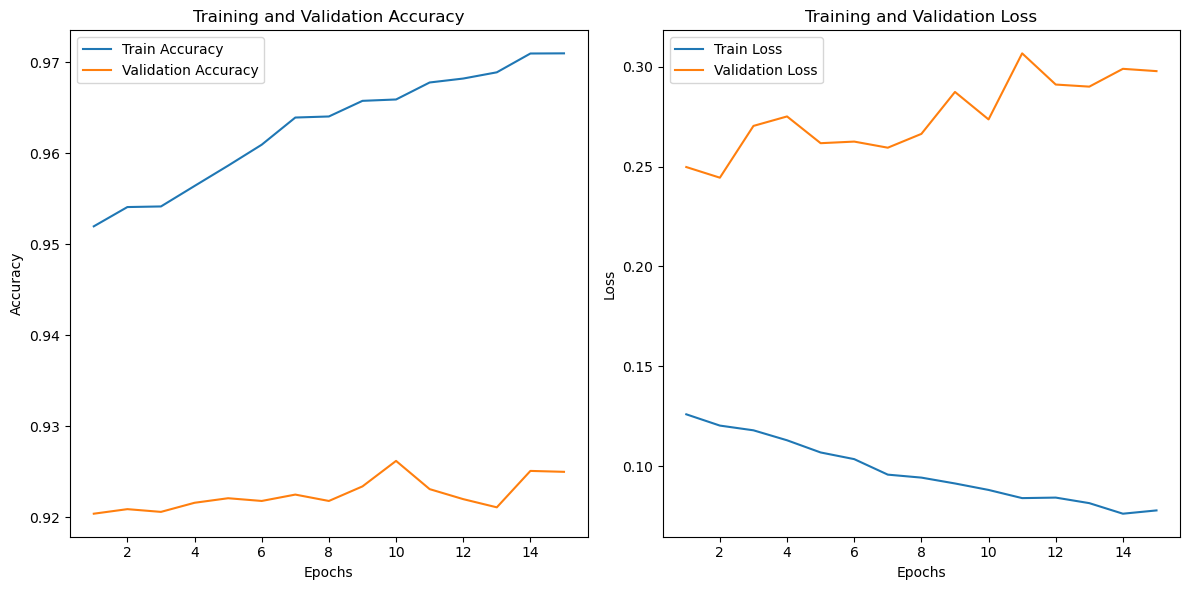

In [22]:
# Отримуємо дані історії тренування
history_dict = history.history
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Створення графіка точності
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Створення графіка втрат
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Показуємо графіки
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 23ms/step


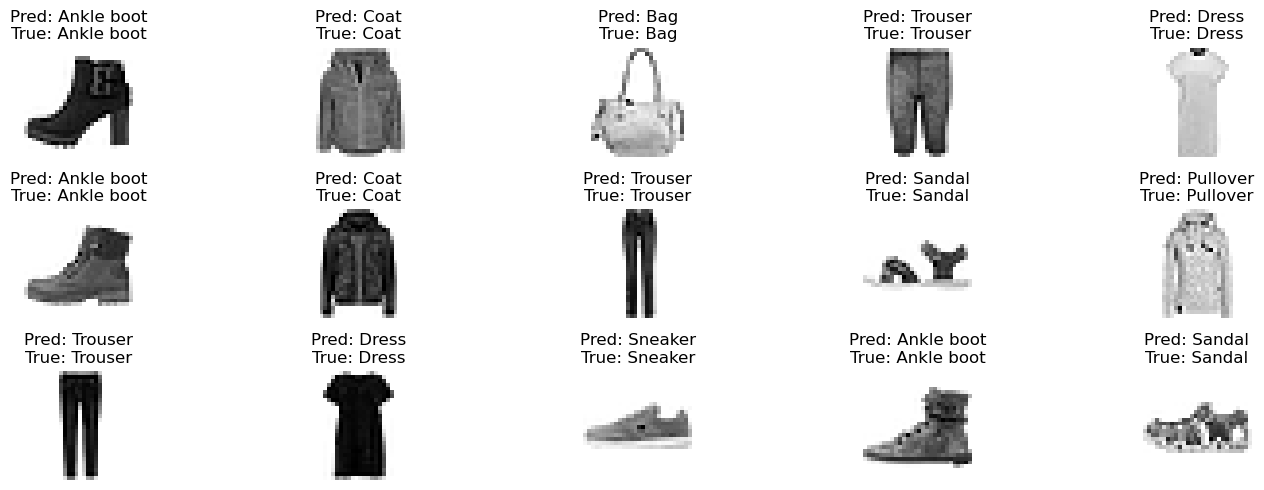

Кількість коректно розпізнаних зображень: 15/15
Процент правильних прогнозів: 100.00%


In [30]:
# Випадкові індекси для тестових зображень
n_test = 15
random_indices = np.random.choice(len(x_test), n_test, replace=False)

# Передбачення для вибраних зображень
predictions = best_model.predict(x_test[random_indices])

# Назви класів для Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Змінна для підрахунку правильних прогнозів
correct_predictions = 0

# Виведення кожного зображення окремо
n_lines = n_test // 5 + (1 if n_test % 5 != 0 else 0);
plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_indices):
    true_label = y_test[idx]  # Правильна відповідь
    predicted_label = np.argmax(predictions[i])  # Прогноз моделі

    # Якщо прогноз правильний, збільшуємо лічильник правильних прогнозів
    if true_label == predicted_label:
        correct_predictions += 1

    # Виведення зображення з прогнозом та реальним класом
    plt.subplot(n_lines, 5, i + 1)
    plt.imshow(x_test[idx], cmap=plt.cm.binary)
    plt.title(f"Pred: {class_names[predicted_label]}\nTrue: {class_names[true_label]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# Обчислюємо відсоток правильних прогнозів
accuracy = (correct_predictions / n_test) * 100
print(f"Кількість коректно розпізнаних зображень: {correct_predictions}/{n_test}")
print(f"Процент правильних прогнозів: {accuracy:.2f}%")